## Autoencoder for Credit Card Anomaly Detection
Annual global fraud losses reached 22 billion dollars in 2015 according to Nilson Report. About every 12 cents per 100 dollars were stolen in the US during the same year. 

Here we develop an Autoencoder neural network model for Anomaly Detection of credit card transaction data. The trained model will be evaluated on a pre-labeled (fraud or not) anonymized dataset. Anomaly detection models are typically trained in an unsupervised or semi-supervised fashion where the volume of "normal" data greatly exceeds that of the fraudulent data such that aspect of "normalcy" can be accurately modeled.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import datetime as dt
import os
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
LABELS = ["Normal", "Fraud"]

RANDOM_SEED = 42

Using TensorFlow backend.


In [2]:
# load the dataset
df = pd.read_csv("data/creditcard.csv")

# Data Exploration 

In [3]:
# check dataset shape
print("Dataset shape: " + str(df.shape))
# check for missing values
print("Missing Values Check: " + str(df.isnull().values.any()))

Dataset shape: (284807, 31)
Missing Values Check: False


In [4]:
# check out the 31 columns
list(df.columns.values)

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [5]:
# analyze classes 
normal = df[df.Class == 0]
fraud = df[df.Class == 1]
print("Shape of the normal class: " + str(normal.shape))
print("Shape of the fraud class: " + str(fraud.shape))

Shape of the normal class: (284315, 31)
Shape of the fraud class: (492, 31)


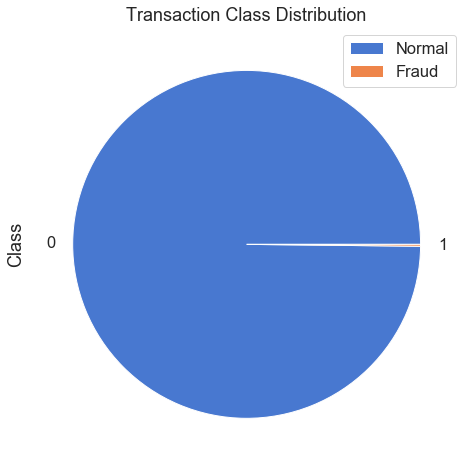

In [6]:
# view data class disribution
fig, ax = plt.subplots(figsize=(12,8))
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'pie')
plt.title("Transaction Class Distribution")
plt.legend(['Normal', 'Fraud'], loc='upper right')

In [7]:
# How different are the money amounts used in different transaction classes?
print("Normal Transactions")
print(normal.Amount.describe())
print("-------------------------------")
print("Fraud Transactions")
print(fraud.Amount.describe())

Normal Transactions
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
-------------------------------
Fraud Transactions
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


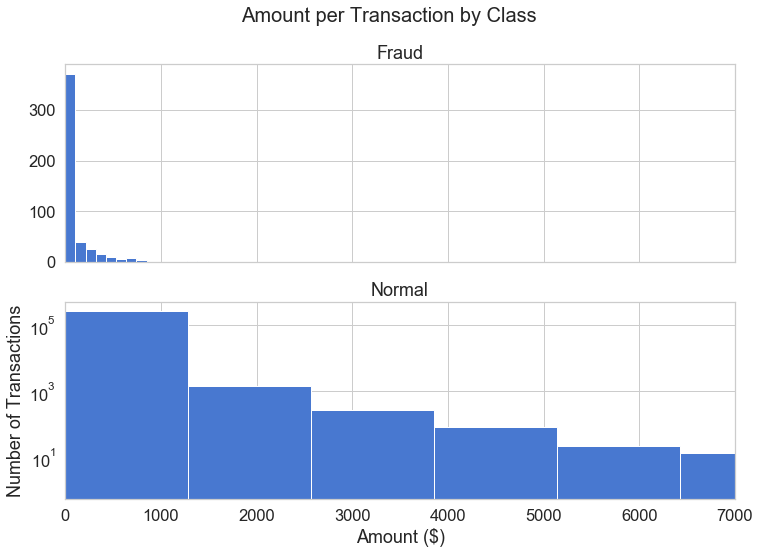

In [8]:
# plot transaction amounts graphically
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
f.suptitle('Amount per Transaction by Class', fontsize=20)

bins = 20
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0,7000))
plt.yscale('log')
plt.show()

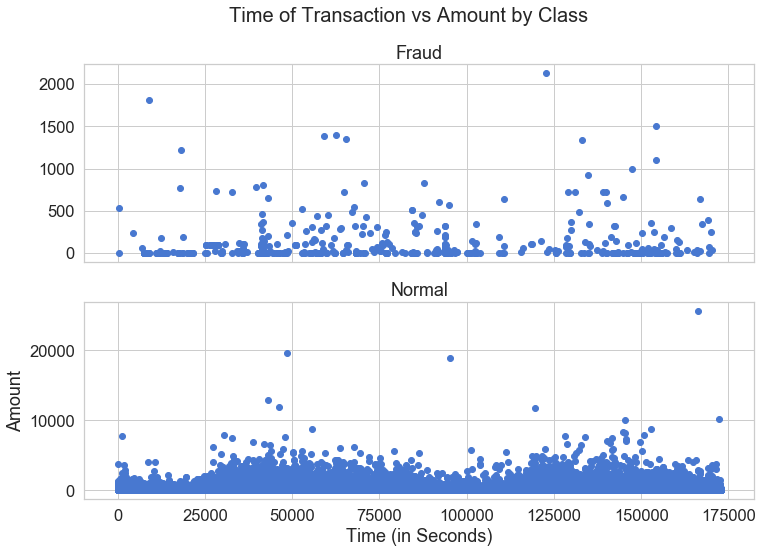

In [9]:
# check if fraudulent transactions occur more often during any certain time?
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
f.suptitle('Time of Transaction vs Amount by Class', fontsize=20)

ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Data Preparation 

In [10]:
# remove the time column as it is of no value and scale the amount values
data = df.drop(['Time'], axis = 1)
print("Dataset shape:", data.shape)

Dataset shape: (284807, 30)


Training the Autoencoder is gonna be a bit different from what we are used to. Let’s say 
you have a dataset containing a lot of non fraudulent transactions at hand. You want to 
detect any anomaly on new transactions. We will create this situation by training our model 
on the normal transactions, only. Reserving the correct class on the test set will give us a
way to evaluate the performance of our model. We will reserve 20% of our data for testing.

In [11]:
# create training & test sets
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
# assign a zero value to the class
X_train = X_train[X_train.Class == 0]
print("Initial training set shape:", X_train.shape)
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values
print("The shape of the training input set is: " + str(X_train.shape))
print("The shape of the test input set is: " + str(X_test.shape))

Initial training set shape: (227451, 30)
The shape of the training input set is: (227451, 29)
The shape of the test input set is: (56962, 29)


In [12]:
# normalize datasets
X_train = np.array(X_train)
X_test = np.array(X_test)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("The shape of the training input set is: " + str(X_train.shape))
print("The shape of the test input set is: " + str(X_test.shape))

The shape of the training input set is: (227451, 29)
The shape of the test input set is: (56962, 29)


In [13]:
# reshape input data for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("The shape of the training input set is: " + str(X_train.shape))
print("The shape of the test input set is: " + str(X_test.shape))

The shape of the training input set is: (227451, 1, 29)
The shape of the test input set is: (56962, 1, 29)


In [14]:
# define the autoencoder model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
encoder = LSTM(32, activation='relu', return_sequences=True, activity_regularizer=regularizers.l2(0.0))(input_layer)
encoder2 = LSTM(8, activation='relu', return_sequences=False)(encoder)
middle = RepeatVector(X_train.shape[1])(encoder2)
decoder = LSTM(8, activation='relu', return_sequences=True)(middle)
decoder2 = LSTM(32, activation='relu', return_sequences=True)(decoder)
outputs = TimeDistributed(Dense(X_train.shape[2]))(decoder2)
autoencoder = Model(inputs=input_layer, outputs=outputs)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 29)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 32)             7936      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 8)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 8)              544       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 32)             5248      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 29)             957       
Total para

In [15]:
# compile & fit model to dataset
nb_epoch = 300
batch_size = 16
autoencoder.compile(optimizer='adam', loss='mse', metrics=['acc'])
history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, 
                          validation_data=(X_test, X_test)).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/300
227451/227451 [==============================] - 112s 494us/step - loss: 0.0032 - acc: 0.7791 - val_loss: 0.0014 - val_acc: 0.7809
Epoch 2/300
227451/227451 [==============================] - 113s 496us/step - loss: 0.0013 - acc: 0.7838 - val_loss: 0.0014 - val_acc: 0.7810
Epoch 3/300
227451/227451 [==============================] - 110s 482us/step - loss: 0.0012 - acc: 0.7838 - val_loss: 0.0012 - val_acc: 0.7810
Epoch 4/300
227451/227451 [==============================] - 103s 452us/step - loss: 0.0011 - acc: 0.7838 - val_loss: 0.0010 - val_acc: 0.7810
Epoch 5/300
227451/227451 [==============================] - 111s 488us/step - loss: 9.9268e-04 - acc: 0.7838 - val_loss: 0.0010 - val_acc: 0.7810
Epoch 6/300
227451/227451 [==============================] - 103s 454us/step - loss: 9.6136e-04 - acc: 0.7837 - val_loss: 9.8803e-04 - val_acc: 0.7810
Epoch 7/300
227451/227451 [==============================] - 98s 433us/step - l

Epoch 55/300
227451/227451 [==============================] - 98s 433us/step - loss: 4.6100e-04 - acc: 0.7860 - val_loss: 4.9366e-04 - val_acc: 0.7813
Epoch 56/300
227451/227451 [==============================] - 98s 433us/step - loss: 4.5952e-04 - acc: 0.7856 - val_loss: 4.8816e-04 - val_acc: 0.7825
Epoch 57/300
227451/227451 [==============================] - 99s 433us/step - loss: 4.5870e-04 - acc: 0.7852 - val_loss: 4.9402e-04 - val_acc: 0.7822
Epoch 58/300
227451/227451 [==============================] - 98s 432us/step - loss: 4.5742e-04 - acc: 0.7857 - val_loss: 5.1034e-04 - val_acc: 0.7823
Epoch 59/300
227451/227451 [==============================] - 98s 432us/step - loss: 4.5588e-04 - acc: 0.7856 - val_loss: 4.8730e-04 - val_acc: 0.7835
Epoch 60/300
227451/227451 [==============================] - 99s 435us/step - loss: 4.5456e-04 - acc: 0.7857 - val_loss: 5.0547e-04 - val_acc: 0.7830
Epoch 61/300
227451/227451 [==============================] - 98s 432us/step - loss: 4.5355e-0

Epoch 109/300
227451/227451 [==============================] - 107s 471us/step - loss: 4.2934e-04 - acc: 0.7847 - val_loss: 4.6807e-04 - val_acc: 0.7820
Epoch 110/300
227451/227451 [==============================] - 109s 478us/step - loss: 4.2937e-04 - acc: 0.7845 - val_loss: 4.4948e-04 - val_acc: 0.7810
Epoch 111/300
227451/227451 [==============================] - 112s 493us/step - loss: 4.2859e-04 - acc: 0.7845 - val_loss: 4.6501e-04 - val_acc: 0.7836
Epoch 112/300
227451/227451 [==============================] - 105s 462us/step - loss: 4.2809e-04 - acc: 0.7845 - val_loss: 4.6563e-04 - val_acc: 0.7819
Epoch 113/300
227451/227451 [==============================] - 102s 449us/step - loss: 4.2838e-04 - acc: 0.7850 - val_loss: 4.6199e-04 - val_acc: 0.7818
Epoch 114/300
227451/227451 [==============================] - 107s 470us/step - loss: 4.2732e-04 - acc: 0.7847 - val_loss: 4.7556e-04 - val_acc: 0.7822
Epoch 115/300
227451/227451 [==============================] - 246s 1ms/step - los

227451/227451 [==============================] - 130s 570us/step - loss: 4.1543e-04 - acc: 0.7850 - val_loss: 4.6201e-04 - val_acc: 0.7806
Epoch 163/300
227451/227451 [==============================] - 129s 568us/step - loss: 4.1351e-04 - acc: 0.7851 - val_loss: 4.5334e-04 - val_acc: 0.7790
Epoch 164/300
227451/227451 [==============================] - 129s 569us/step - loss: 4.1453e-04 - acc: 0.7845 - val_loss: 4.4010e-04 - val_acc: 0.7804
Epoch 165/300
227451/227451 [==============================] - 130s 571us/step - loss: 4.1751e-04 - acc: 0.7843 - val_loss: 4.4995e-04 - val_acc: 0.7792
Epoch 166/300
227451/227451 [==============================] - 130s 571us/step - loss: 4.1409e-04 - acc: 0.7847 - val_loss: 4.9431e-04 - val_acc: 0.7821
Epoch 167/300
227451/227451 [==============================] - 130s 571us/step - loss: 4.1236e-04 - acc: 0.7847 - val_loss: 4.3636e-04 - val_acc: 0.7811
Epoch 168/300
227451/227451 [==============================] - 129s 568us/step - loss: 4.1224e-0

227451/227451 [==============================] - 113s 496us/step - loss: 4.0626e-04 - acc: 0.7844 - val_loss: 4.4144e-04 - val_acc: 0.7845
Epoch 216/300
227451/227451 [==============================] - 104s 457us/step - loss: 4.0518e-04 - acc: 0.7847 - val_loss: 4.3721e-04 - val_acc: 0.7812
Epoch 217/300
227451/227451 [==============================] - 111s 488us/step - loss: 4.0541e-04 - acc: 0.7850 - val_loss: 4.3121e-04 - val_acc: 0.7834
Epoch 218/300
227451/227451 [==============================] - 106s 466us/step - loss: 4.0527e-04 - acc: 0.7851 - val_loss: 4.4754e-04 - val_acc: 0.7844
Epoch 219/300
227451/227451 [==============================] - 105s 463us/step - loss: 4.0436e-04 - acc: 0.7848 - val_loss: 4.2789e-04 - val_acc: 0.7820
Epoch 220/300
227451/227451 [==============================] - 114s 502us/step - loss: 4.0582e-04 - acc: 0.7844 - val_loss: 4.4108e-04 - val_acc: 0.7771
Epoch 221/300
227451/227451 [==============================] - 102s 448us/step - loss: 4.0527e-0

227451/227451 [==============================] - 127s 558us/step - loss: 4.0031e-04 - acc: 0.7854 - val_loss: 4.4329e-04 - val_acc: 0.7822
Epoch 269/300
227451/227451 [==============================] - 130s 570us/step - loss: 4.0063e-04 - acc: 0.7853 - val_loss: 4.2748e-04 - val_acc: 0.7813
Epoch 270/300
227451/227451 [==============================] - 129s 569us/step - loss: 4.0104e-04 - acc: 0.7852 - val_loss: 4.2766e-04 - val_acc: 0.7830
Epoch 271/300
227451/227451 [==============================] - 130s 570us/step - loss: 4.0097e-04 - acc: 0.7854 - val_loss: 4.4229e-04 - val_acc: 0.7845
Epoch 272/300
227451/227451 [==============================] - 129s 568us/step - loss: 3.9919e-04 - acc: 0.7849 - val_loss: 4.2915e-04 - val_acc: 0.7824
Epoch 273/300
227451/227451 [==============================] - 127s 558us/step - loss: 4.0010e-04 - acc: 0.7853 - val_loss: 4.2847e-04 - val_acc: 0.7837
Epoch 274/300
227451/227451 [==============================] - 132s 581us/step - loss: 4.0073e-0

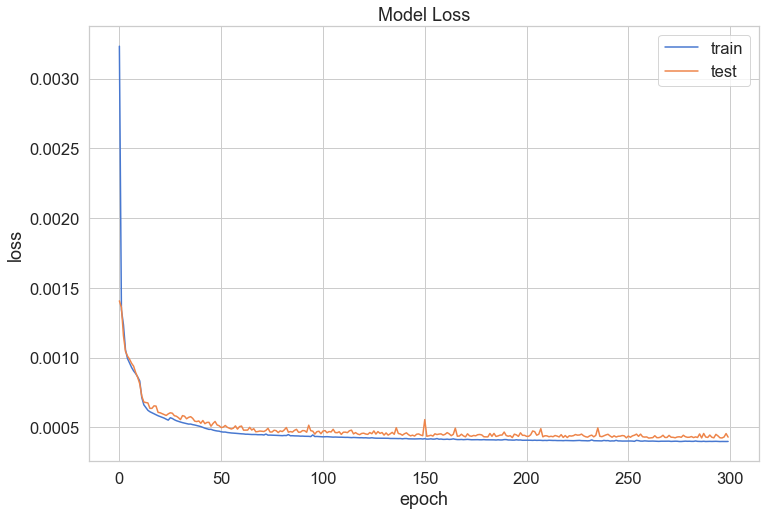

In [64]:
# review model results
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [65]:
# evaluate loss on test set
yhat = autoencoder.predict(X_test)
predictions = yhat.reshape(yhat.shape[0], yhat.shape[2])
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
mse = np.mean(np.power(Xtest - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.000430,0.001720
std,0.001548,0.041443
min,0.000011,0.000000
25%,0.000130,0.000000
50%,0.000232,0.000000
75%,0.000430,0.000000
max,0.092397,1.000000


Text(0.5, 1.0, 'Reconstruction Error without the Fraud Data')

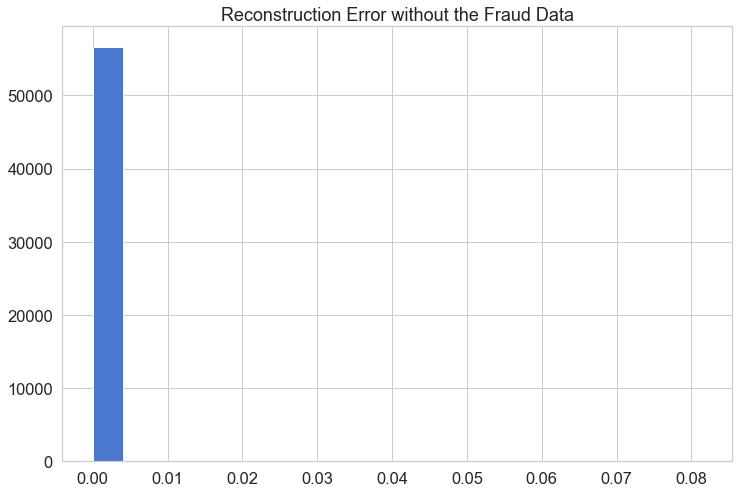

In [68]:
# reconstruction error without the fraud data
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']==0 & (error_df['reconstruction_error'] < 0.05))]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=20)
plt.title('Reconstruction Error without the Fraud Data')

Text(0.5, 1.0, 'Reconstruction Error with Fraud Data')

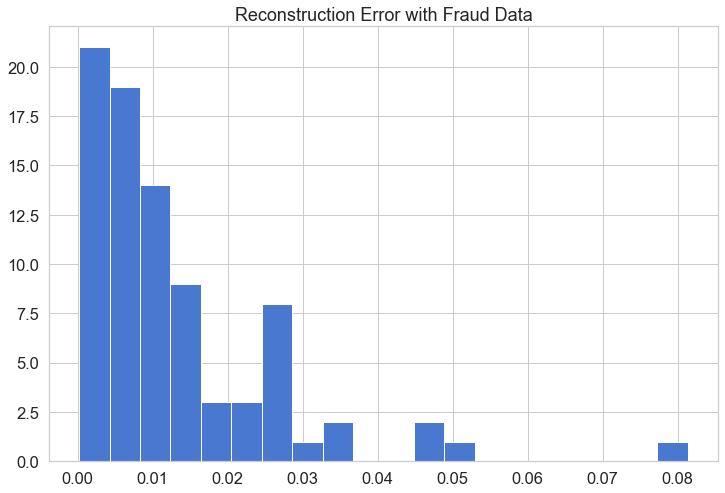

In [69]:
# reconstruction error with the fraud data
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']==1 & (error_df['reconstruction_error'] < 0.05))]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=20)
plt.title('Reconstruction Error with Fraud Data')

In [70]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

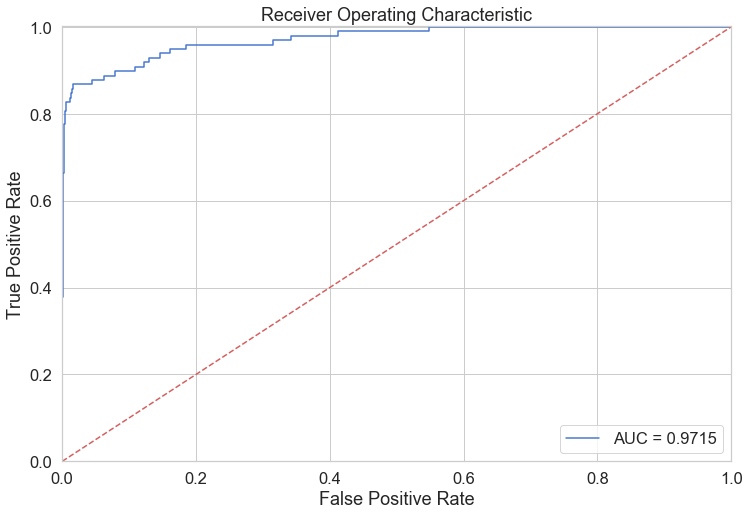

In [71]:
# ROC curves are very useful tool for understanding the performance of binary classifiers. 
# We have a very imbalanced dataset. Nonetheless, let’s have a look at our ROC curve:

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, 
over different threshold values. Basically, we want the blue line to be as close as 
possible to the upper left corner.

# Precision & Recall Analysis
precision = true positives / true positives + false positives

recall = true positives / true positives + false negatives

Precision measures the relevancy of obtained results. Recall, on the other hand, measures 
how many relevant results are returned. Both values can take values between 0 and 1. 
You would love to have a system with both values being equal to 1.

High recall but low precision means many results, most of which has low or no relevancy. 
When precision is high but recall is low we have the opposite — few returned results with 
very high relevancy. Ideally, you would want high precision and high recall — 
many results with that are highly relevant.

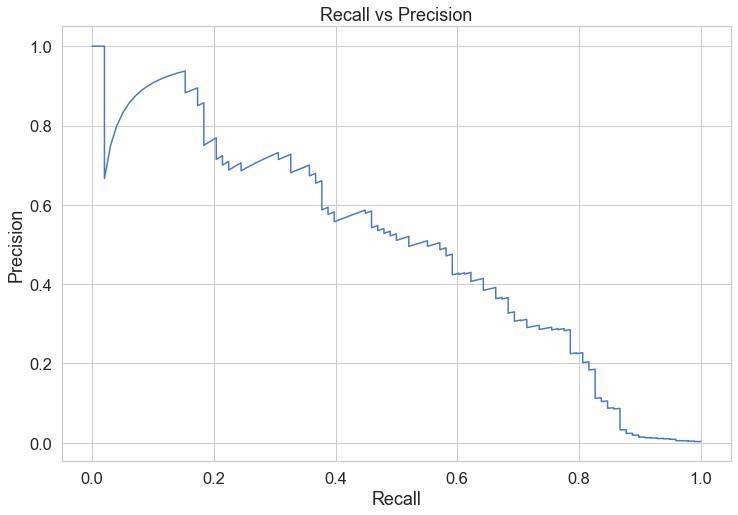

In [72]:
# plot precision vs. recall
fig, ax = plt.subplots(figsize=(12,8))
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high 
precision relates to a low false positive rate, and high recall relates to a low false 
negative rate. High scores for both show that the classifier is returning accurate 
results (high precision), as well as returning a majority of all positive results 
(high recall).

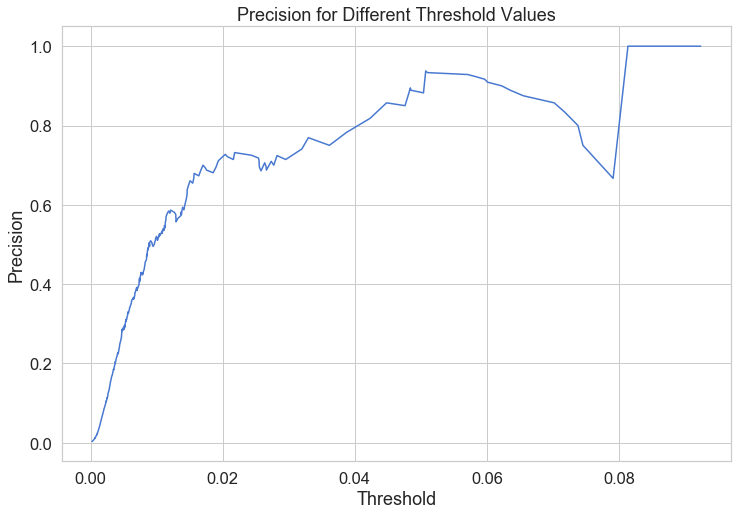

In [74]:
# plot precision vs. error threshold
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for Different Threshold Values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

As the reconstruction error increases our precision rises as well

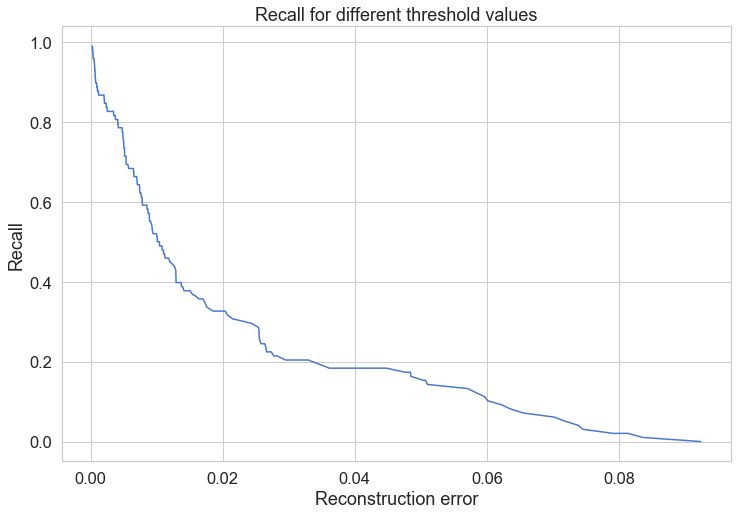

In [30]:
# plot recall vs. error threshold
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases 
the recall decreases.

# Fraud Prediction
Our model is a bit different; it doesn’t know how to predict new values. But we don’t 
need that. In order to predict whether or not a new/unseen transaction is normal or 
fraudulent, we’ll calculate the reconstruction error from the transaction data itself. 
If the error is larger than a predefined threshold, we’ll mark it as a fraud 
(since our model should have a low error on normal transactions). 

In [61]:
# choose a fraud error threshold
threshold = 0.00202

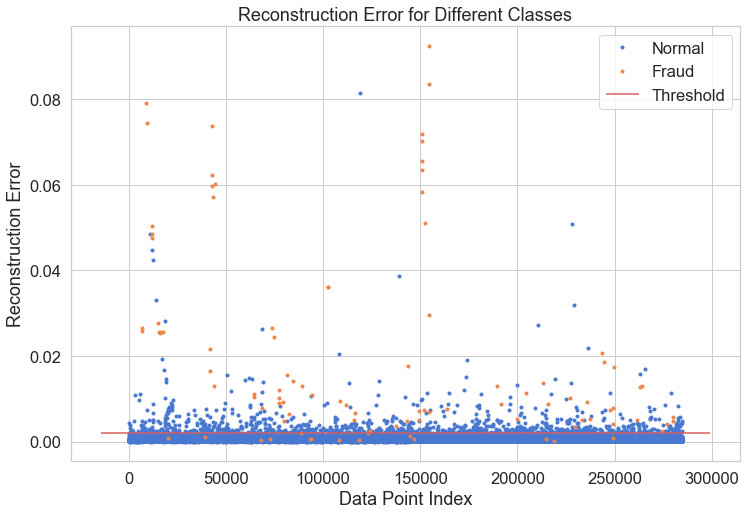

In [75]:
# review fraud prediction on the test set
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.0, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error for Different Classes")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.show()

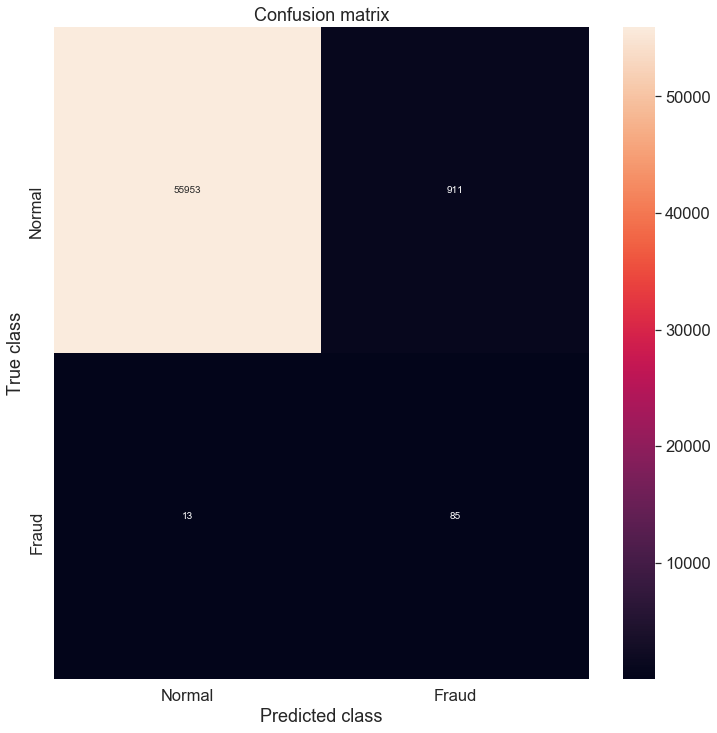

In [76]:
# let's look at the corresponding confusion matrix
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Our model seems to catch most of the fraudulent cases and does a pretty good job of not classifying normal transactions as fraudulent transactions. 